In [1]:
import argparse
import os
import time
import numpy as np
import sys
import torch
from torch.utils.data import DataLoader
from TM_model import Model
from TM_model.archs import flow_warp
import cv2
from utils.utils_image import test_tensor_img
from data.dataset_LMDB_train import DataLoaderTurbVideoTest
# from data.dataset_LMDB_train import DataLoaderTurbVideo
import json, math
# from utils.simulator_zernike_1D import Simulator
import matplotlib.pyplot as plt
from torchmetrics.functional import peak_signal_noise_ratio as tmf_psnr
from utils.NAFNet_arch import NAFNet_zer

/home/zhan3275/env/bimamba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Args:
    def __init__(self):
        self.batch_size =1
        self.patch_size = 240
        self.num_frames = 30
        self.chunk_frames = 30
        self.data_path = '/home/zhan3275/data/lmdb_ATSyn/test_lmdb/'
        self.info_path = '/home/zhan3275/data/lmdb_ATSyn/test_lmdb/test_info.json'
        # self.data_path = '/home/zhan3275/data/lmdb_ATSyn/train_lmdb/'
        # self.info_path = '/home/zhan3275/data/lmdb_ATSyn/train_lmdb/train_info.json'
        # self.result_path = '/home/zhan3275/data/simulated_data/test_MBP_video'
        self.model_path = 'model_zoo/model_dynamic2.pth'
        self.num_workers = 8
        self.model = 'MambaTM'
        self.n_features = 16
        self.n_blocks = 6
        self.future_frames = 2
        self.past_frames = 2
        self.activation = 'gelu'
        self.output_all = True
        self.reblur_path = "/home/zhan3275/turb/recon/MambaTM/LPD_learning/model_zoo/NAF_decoder.pth"
        
def get_args():
    return Args()

In [3]:
class TurbSim(object):
    def __init__(self, nb, width, ckpt_path):
        self.blur_model = NAFNet_zer(in_channels=1, out_channel=1, width=width, middle_blk_num=1,
                      enc_blk_nums=[1,1,1,nb], dec_blk_nums=[1,1,1,1]).cuda()
        loaded = torch.load(ckpt_path)
        self.blur_model.load_state_dict(loaded["decoder"])
        for prm in self.blur_model.parameters():
            prm.requires_grad = False
        if torch.cuda.device_count()>1:
            self.blur_model = torch.nn.DataParallel(self.blur_model, device_ids=[i for i in range(torch.cuda.device_count())]).cuda()
        print("TurbSim loaded!")
    
    def reblur(self, img, LPD):
        B, T, C, H, W = img.shape
        img = img.flatten(0, 1)
        LPD = LPD.flatten(0, 1)
        tilt, mu, logvar = LPD[:,:2,:,:], LPD[:,2:3,:,:], LPD[:,3:4,:,:]
        log_var = torch.clamp(logvar, min=-10.0, max = 10.0)
        tilt_img = flow_warp(img, tilt)
        z = torch.exp(0.5 * logvar) * torch.randn_like(logvar) + mu
        kld = -0.5 * torch.mean(1 + log_var - mu**2 - log_var.exp())
        # turb_img = self.blur_model(tilt_img.mean(1, keepdim=True), z)
        turb_img = self.blur_model(tilt_img, z)
        return tilt_img.view(B, T, C, H, W), turb_img.view(B, T, -1, H, W), kld

In [4]:
args = get_args()
input_dir = args.data_path
model_path = args.model_path
patch_size = args.patch_size

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TS = TurbSim(8, 16, args.reblur_path)

TurbSim loaded!


In [5]:
def get_psnr(inp, redgd):
    psnr_list = []
    for b in range(inp.shape[0]):
        for i in range(inp.shape[1]):
            img = inp[b, i, ...].data.clamp_(0, 1).unsqueeze(0)
            img_gt = redgd[b, i, ...].data.clamp_(0, 1).unsqueeze(0)
            psnr_list.append(tmf_psnr(img, img_gt, data_range=1.0).item())
    return sum(psnr_list)/len(psnr_list)

def cosine(start_value, end_value, steps, current_step):
    cosine_value = (1 + math.cos(math.pi * current_step / steps)) / 2
    current_value = start_value + (end_value - start_value) * (1 - cosine_value)
    return current_value

def exponential_decay(start_value, end_value, steps, current_step):
    decay_rate = math.log(end_value / start_value) / steps
    current_value = start_value * math.exp(decay_rate * current_step)
    return current_value

In [6]:
model = Model(args).cuda()
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['state_dict'] if 'state_dict' in checkpoint.keys() else checkpoint)
model = model.eval()
for param in model.parameters():
    param.requires_grad = False

In [7]:
def rf_reg(z, w=[1e-5, 1e-5, 1e-5]):
    return w[0] * torch.norm(z[:, 1:, :, ...]-z[:, :-1, :, ...], p=1) \
        + w[1] * torch.norm(z[...,1:, :]-z[...,:-1, :], p=1) \
        + w[2] * torch.norm(z[...,:, 1:]-z[...,:, :-1], p=1)
    
def cost(res, sim, inp, lpd_step, sigma=1, factor=1):
    redgd = sim.blur_model(res[0], lpd_step[0]).unsqueeze(dim=0)
    return 1/(2*sigma**2) * torch.norm(inp[0]-redgd), redgd, torch.norm(inp[0]-redgd)
    # return 1/(2*sigma**2) * torch.norm(inp[:,2:-2,...]-redgd) \
    #         + factor*rf_reg(zer_step[:, :, :2, ...], [1e-5, 2e-5, 2e-5]) \
    #         + factor*rf_reg(zer_step[:, :, 2:, ...], [5e-6, 1e-5, 1e-5]) \
    #         + factor*2e-5 * torch.norm(zer_step[:,:,:2,...]) \
    #         + factor*1e-5 * torch.norm(zer_step[:,:,2:,...]), redgd, torch.norm(inp[:,2:-2,...]-redgd)

In [8]:
brs_sample_path = "/home/zhan3275/data/BRIAR_video_classifier/BRIAR_test_set/videos_before_restoration/BRS3_EP4.2.0_G03283_field_0000000029/"
brs_images = [cv2.cvtColor(cv2.imread(os.path.join(brs_sample_path, f"frame_{i+22:05d}.png")), cv2.COLOR_BGR2RGB) for i in range(30)]
input_all = torch.stack([torch.tensor(img)/255.0 for img in brs_images], 0).permute(0,3,1,2).unsqueeze(0).cuda()

In [9]:
input_all.shape

torch.Size([1, 30, 3, 240, 240])

In [11]:
res, lpd = model(input_all)
tilt, redgd, kld = TS.reblur(res, lpd)

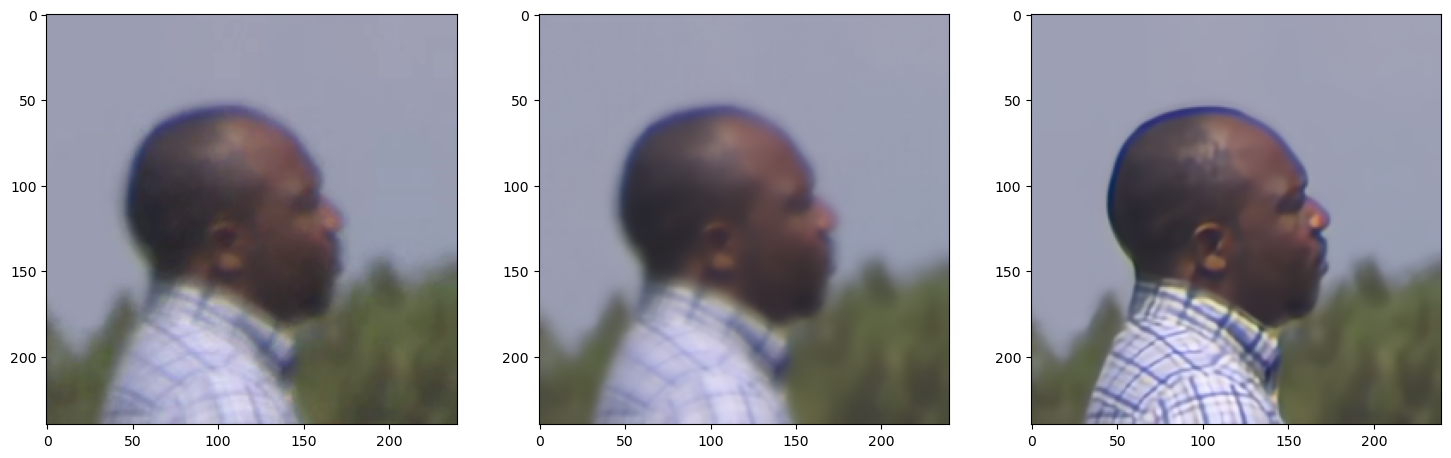

In [13]:
idx = 25
f = plt.figure(figsize=(18,6))
f.add_subplot(1, 3, 1)
plt.imshow(input_all[0,idx,...].permute(1,2,0).detach().cpu().numpy())
f.add_subplot(1, 3, 2)
plt.imshow(redgd[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
f.add_subplot(1, 3, 3)
plt.imshow(res[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
plt.show(block=True)

In [14]:
# lpd_blur = torch.randn((1,30,2,240,240), device='cuda') 
# lpd_blur.requires_grad = True
steps = 500
res, lpd = model(input_all)
mu, logvar = lpd[:,:,2:3,:,:], lpd[:,:,3:4,:,:]
lpd_blur = torch.exp(0.5 * logvar) * torch.randn_like(logvar) + mu
lpd_blur.requires_grad = True
psnr_list = []
for i in range(steps):
    fct = exponential_decay(1, 0.02, steps, i)
    G, redgd, error = cost(res, TS, input_all, lpd_blur, sigma=1, factor=fct)
    G.backward()
    psnr_list.append(get_psnr(input_all, redgd))
    if i%10 ==0:
        print(i, fct, G.item(), error.item(), get_psnr(input_all, redgd))
    if i==70:
        lpd_70 = lpd_blur.clone()
    lpd_blur.requires_grad = False
    lpd_blur = lpd_blur - 500 * lpd_blur.grad + torch.randn_like(lpd_blur)*0.01  # 0.001 no effect, 0.05 obvious effect
    lpd_blur.requires_grad = True
    # zer_.grad.zero_()

OutOfMemoryError: CUDA out of memory. Tried to allocate 80.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 81.06 MiB is free. Including non-PyTorch memory, this process has 15.69 GiB memory in use. Of the allocated memory 15.11 GiB is allocated by PyTorch, and 208.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [21]:
# lpd_blur = torch.randn((1,30,2,240,240), device='cuda') 
# lpd_blur.requires_grad = True
steps = 500
res, lpd = model(input_all)
mu, logvar = lpd[:,:,2:3,:,:], lpd[:,:,3:4,:,:]
lpd_blur = torch.exp(0.5 * logvar) * torch.randn_like(logvar) + mu
lpd_blur.requires_grad = True
psnr_list = []
for i in range(steps):
    fct = exponential_decay(1, 0.02, steps, i)
    G, redgd, error = cost(res, TS, input_all, lpd_blur, sigma=1, factor=fct)
    G.backward()
    psnr_list.append(get_psnr(input_all, redgd))
    if i%10 ==0:
        print(i, fct, G.item(), error.item(), get_psnr(input_all, redgd))
    if i==70:
        lpd_70 = lpd_blur.clone()
    lpd_blur.requires_grad = False
    lpd_blur = lpd_blur - 500 * lpd_blur.grad + torch.randn_like(lpd_blur)*0.01  # 0.001 no effect, 0.05 obvious effect
    lpd_blur.requires_grad = True
    # zer_.grad.zero_()

0 1.0 33.84175491333008 67.68350982666016 30.618727429707846
10 0.9247420362361861 31.605371475219727 63.21074295043945 31.21289196014404
20 0.8551478335822477 29.119693756103516 58.23938751220703 31.927358627319336
30 0.7907911489098108 27.060848236083984 54.12169647216797 32.57480392456055
40 0.7312778172804115 25.543493270874023 51.08698654174805 33.08333428700765
50 0.6762433378062414 24.195579528808594 48.39115905761719 33.55499528249105
60 0.6253506411940987 22.984590530395508 45.969181060791016 34.00224157969157
70 0.5782880252994355 21.968271255493164 43.93654251098633 34.39791208902995
80 0.534767246046403 21.169448852539062 42.338897705078125 34.7229424794515
90 0.4945217520213682 20.568145751953125 41.13629150390625 34.97620162963867
100 0.45730505192732634 20.122421264648438 40.244842529296875 35.16859296162923
110 0.4228892049003706 19.790170669555664 39.58034133911133 35.314262008666994
120 0.39106342444187037 19.53685188293457 39.07370376586914 35.42632230122884
130 0.36

In [27]:
redgd_70 = TS.blur_model(res[0], lpd_70[0]).unsqueeze(dim=0)

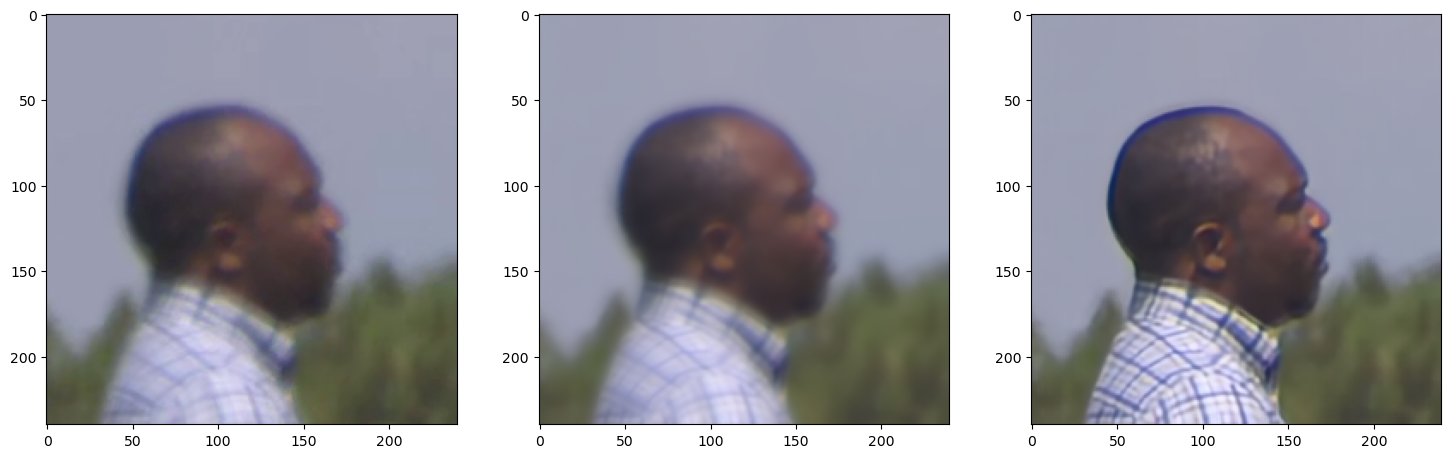

In [22]:
idx = 25
f = plt.figure(figsize=(18,6))
f.add_subplot(1, 3, 1)
plt.imshow(input_all[0,idx,...].permute(1,2,0).detach().cpu().numpy())
f.add_subplot(1, 3, 2)
plt.imshow(redgd[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
f.add_subplot(1, 3, 3)
plt.imshow(res[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
plt.show(block=True)

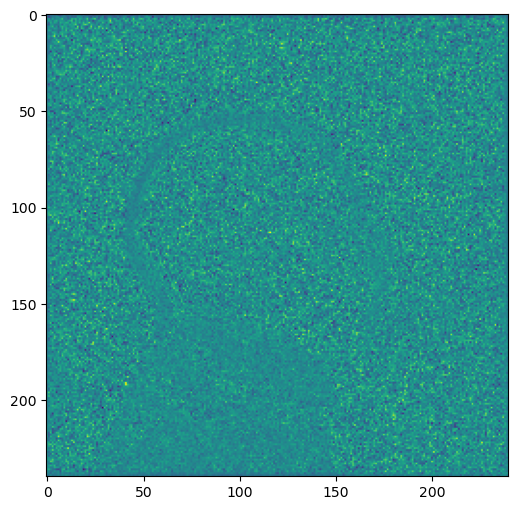

In [30]:
f = plt.figure(figsize=(6,6))
plt.imshow(lpd_blur[0,idx,0,...].detach().cpu().numpy())

plt.show(block=True)

In [ ]:
plt.figure(figsize=(6,6))

plt.plot(PSNRs, marker="*", color="r", linewidth=1)
plt.xlabel('Steps', color='b')
plt.ylabel('PSNR', color='r')

In [29]:
lpd_blur = torch.exp(0.5 * logvar) * torch.randn_like(logvar) + mu

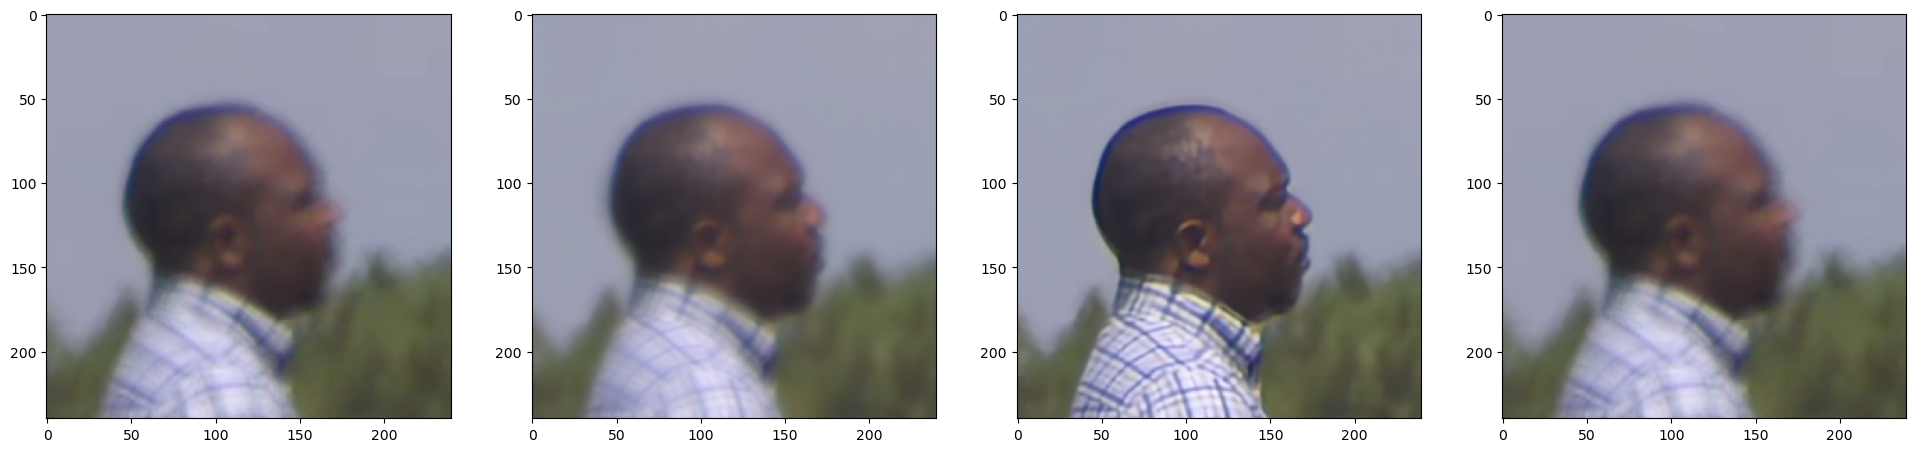

In [16]:
idx = 25
f = plt.figure(figsize=(24,6))
f.add_subplot(1, 4, 1)
plt.imshow(input_all[0,idx+2,...].permute(1,2,0).detach().cpu().numpy())
f.add_subplot(1, 4, 2)
plt.imshow(redgd[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
f.add_subplot(1, 4, 3)
plt.imshow(res[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
f.add_subplot(1, 4, 4)
plt.imshow(input_all[0,idx+2,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy())
plt.show(block=True)

In [28]:
output_path = "/home/zhan3275/data/tmp"
for idx in range(30):
    inp = input_all[0,idx,...].permute(1,2,0).detach().cpu().numpy()
    rd = redgd_70[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy()
    r = res[0,idx,...].permute(1,2,0).clamp(0,1).detach().cpu().numpy()
    cv2.imwrite(os.path.join(output_path, "input", f"{idx:02d}.png"), cv2.cvtColor((inp*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(output_path, "redgd_70", f"{idx:02d}.png"), cv2.cvtColor((rd*255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(os.path.join(output_path, "restore", f"{idx:02d}.png"), cv2.cvtColor((r*255).astype(np.uint8), cv2.COLOR_RGB2BGR))

In [29]:
PSNR_lists = []
error_lists = []

count = 0
for data in test_loader:
# for data in train_loader:
    print(count)
    PSNR_list = []
    error_list = []
    input_all = data[0][..., :args.patch_size, :args.patch_size].cuda()
    gt = data[1][..., :args.patch_size, :args.patch_size].cuda()
    # print(data[0][..., :args.patch_size, :args.patch_size].shape)

    zer_ = torch.randn((1,26,35,240,240), device='cuda') 
    zer_.requires_grad = True
    res = model(input_all)
    for i in range(100):
        fct = exponential_decay(10, 0.1, 100, i)
        G, redgd, error = cost(res, simulator, input_all, zer_, ksize=45, sigma=1, factor=fct)
        G.backward()
        error_list.append(error.detach().item())
        PSNR_list.append(get_psnr(input_all[:, 2:-2, ...].detach(), redgd.detach()))
        zer_.requires_grad = False
        zer_ = zer_ - 500 * zer_.grad + torch.randn_like(zer_)*0.01  # 0.001 no effect, 0.05 obvious effect
        zer_.requires_grad = True
    count += 1
    PSNR_lists.append(PSNR_list)
    error_lists.append(error_list)
    if count == 10:
        break

0
1
2
3
4
5
6
7
8
9


In [30]:
PSNRs = []
errors = []
for i in range(100):
    PSNRs.append(sum([l[i] for l in PSNR_lists])/10)
    errors.append(sum([l[i] for l in error_lists])/10)

<Figure size 864x864 with 0 Axes>

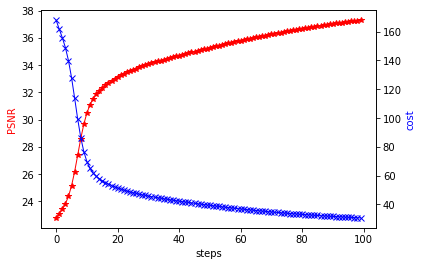

In [15]:
plt.figure(figsize=(12,12))

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(PSNRs, marker="*", color="r", linewidth=1)
ax2.plot(errors, marker="x", color="b", linewidth=1)

ax1.set_xlabel('steps')
ax1.set_ylabel('PSNR', color='r')
ax2.set_ylabel('cost', color='b')

plt.show()

Text(0, 0.5, 'PSNR')

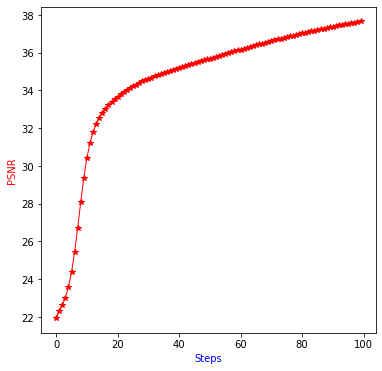

In [31]:
plt.figure(figsize=(6,6))

plt.plot(PSNRs, marker="*", color="r", linewidth=1)
plt.xlabel('Steps', color='b')
plt.ylabel('PSNR', color='r')

In [11]:
# def cost(model, sim, inp, zer_step, ksize=67, sigma=1, factor=1):
#     res = model(inp)
#     redegraded = []
#     redgd = sim(res[0], zer_step[0].permute(0,2,3,1), ksize).unsqueeze(dim=0)
#     # print(torch.norm(inp[:,2:-2,...]-redgd))
#     # redgd = torch.cat(redegraded, dim=1)
#     return 1/(2*sigma**2) * torch.norm(inp[:,2:-2,...]-redgd) \
#             + 1/10000 * factor * torch.norm(zer_step[:,:,:2,...]) \
#             + 1/1000 * factor * torch.norm(zer_step[:,:,2:,...]), res, redgd

def cost2(res, sim, inp, zer_step, ksize=65, sigma=1, factor=1):
    redgd = sim(res[0], zer_step[0].permute(0,2,3,1), ksize).unsqueeze(dim=0)
    # print(torch.norm(inp[:,2:-2,...]-redgd))
    return 1/(2*sigma**2) * torch.norm(inp[:,2:-2,...]-redgd) \
            + 1/10000 * factor * torch.norm(zer_step[:,:,:2,...]) \
            + 1/1000 * factor * torch.norm(zer_step[:,:,2:,...]), res, redgd